In [1]:
from neuron import h,gui
from matplotlib.pyplot import *
from numpy import *
import pandas as pd
#from numpy import *
#from matplotlib.pyplot import *
import os,shutil,pickle
from multiprocessing import Pool,Process
import time
from mpl_toolkits.mplot3d import axes3d, Axes3D
from scipy import integrate
from ChR2Dynamics import ChR2Dynamics
from ptn_sim_morphology import *
from ptn_sim_optostim import optostim
from ptn_sim_soma import sphere_equi,soma_integrate_light
from ptn_sim_neuron import *

ImportError: No module named neuron

            name datatype units      value
0           ChR2     bool  none       True
1     ChR2_level     real  none        0.8
2            tau     real    ms         50
3              R     real  MOhm        250
4         soma_z     real    um         50
5         soma_x     real    um          0
6         soma_y     real    um        650
7   morph_source   string  none      ALLEN
8  morph_cell_id      int  none  471129934


(-180.4132915883, 153.9738433903, -686.3918344931301, 35.45033048773001)

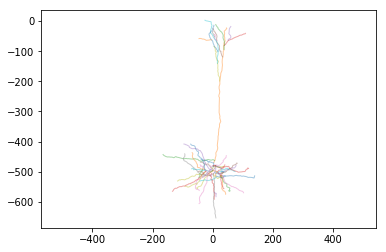

In [2]:
class nrn_sim(object):
    NBranches=0
    somata=[]
    branches_nrn=[]
    N=[]
    Ncnt=0
    def __init__(self):
        pass

    
            
    def nrn_soma_sec(self,neuron_id):
        #print neuron_id
        return [s for s in h.allsec() if int(s.name()[1:4])==neuron_id and s.name()[5]=='s'][0]
    
    def nrn_dendrite_sec(self,neuron_id,branch_id):
        return [s for s in h.allsec() if int(s.name()[1:4])==neuron_id and
                int(s.name()[6:10])==branch_id and s.name()[5]=='d'][0]
    def insert_neuron(self,n):
        #self.clear()
        self.Ncnt+=1
        self.N.append(n)
        
        neuron_id=n.neuron_id
        soma_CoM,soma_R=n.morph.soma_geometry()
        h('create n{:03}_s0000'.format(n.neuron_id))
        soma= self.nrn_soma_sec(neuron_id)
        soma.L=soma.diam=soma_R*20
        self.somata.append(soma)
        
        branches=n.morph.branches
        swc=n.morph.swc
        segments=n.morph.segments
        
        self.NBranches=len(branches)    
        h.pt3dclear(sec=soma)
        h.pt3dadd(soma_CoM[0],soma_CoM[1]-5,soma_CoM[2],soma.L,soma)
        h.pt3dadd(soma_CoM[0],soma_CoM[1],soma_CoM[2],soma.L,soma)
        
        
        soma.insert('hh')
        soma.Ra=100
        soma.cm=1
        """for seg in soma:
            seg.hh.gnabar=0.12
            seg.hh.gkbar=0.036
            seg.hh.gl=0.0003
            seg.hh.el=-54.3"""

        for iBranch in range(self.NBranches):
            h('create n{:03}_d{:04}'.format(neuron_id,iBranch))
            cBranch_nrn=self.nrn_dendrite_sec(neuron_id,iBranch)
            #print cBranch_nrn.name()
            cBranch_nrn.Ra=100
            cBranch_nrn.cm=1
            cBranch_segments=segments[segments['branch_id']==iBranch]
            #print cBranch_nrn.name(),len(cBranch_segments)
            cBranch_nrn.L=len(cBranch_segments)*SEGMENT_LENGTH
            cBranch_nrn.diam=5
            cBranch_nrn.insert('pas')
            cBranch_nrn.nseg=len(cBranch_segments)
            for seg in cBranch_nrn:
                seg.pas.g=0.002
                seg.pas.e=-65
                
            cBranchParentID=int(branches[branches['branch_id']==iBranch]['parent_branch'])
            cBranchPoint0_ID=int(branches[branches['branch_id']==iBranch]['start'])
            cBranchPoint1_ID=int(branches[branches['branch_id']==iBranch]['end'])
            
            """h.pt3dclear(sec=cBranch_nrn)
            for ptSWC in range(cBranchPoint0_ID,cBranchPoint1_ID):
                cBranchPoint=swc[swc['id']==cBranchPoint0_ID][['x','y','z']]
            #cBranchPoint1=swc[swc['id']==cBranchPoint1_ID][['x','y','z']]
            
            #print double(cBranchPoint0['x'])
            
                h.pt3dadd(double(cBranchPoint['x']),double(cBranchPoint['y']),double(cBranchPoint['z']),1,cBranch_nrn)
            """
            #h.pt3dadd(double(cBranchPoint1['x']),double(cBranchPoint1['y']),double(cBranchPoint1['z']),1,cBranch_nrn)
            
            if cBranchParentID==-1:
                cBranch_nrn.connect(soma(0))
            else:
                cBranchParentSec=self.nrn_dendrite_sec(neuron_id,cBranchParentID)
                cBranch_ParentBranch_Point0_ID=int(branches[branches['branch_id']==cBranchParentID]['start'])
                cBranch_ParentBranch_Point1_ID=int(branches[branches['branch_id']==cBranchParentID]['end'])
                cBranch_ParentPoint_ID=int(branches[branches['branch_id']==iBranch]['parent_point'])
                
                frac=(cBranch_ParentPoint_ID-cBranch_ParentBranch_Point0_ID)*1./(cBranch_ParentBranch_Point1_ID-cBranch_ParentBranch_Point0_ID)
                cBranch_nrn.connect(cBranchParentSec(frac))
        for sec in h.allsec():
            h.pt3dclear(sec=sec)




            
                
    def run(self,tstop=100.):
        v_s=h.Vector()
        v_d1=h.Vector()
        v_d2=h.Vector()

        t=h.Vector()#(linspace(0.))
        #i_d3=h.Vector()
        #t=h.Vector()
        t.record(h._ref_t)
        v_s.record(h.soma(0.5)._ref_v)
        v_d1.record(self.branches_nrn[1](0.5)._ref_v)
        v_d2.record(self.branches_nrn[2](0.5)._ref_v)
        #v_d3.record(dend3(0.8)._ref_v)
        h.tstop=tstop
        h.run()
        plot(t,v_s)
        #plot(t,v_d1)
        #plot(t,v_d2)
        
    def clear(self):
        for d in h.allsec():
            h.delete_section(d)
    def topology(self):

        print '-------'
        h.topology()
        
    def current_to_nrnstim(self,tstim,istim,comp,frac):    
        Nq=len(istim)                  
        dt=tstim[1]-tstim[0]

        stim=[None for i in range(Nq)]
        #comp=h.soma#branches_nrn[0]
        for jstim in range(Nq):
            stim[jstim]=h.IClamp(comp(frac))
            stim[jstim].dur=dt
            stim[jstim].amp=istim[jstim]
            stim[jstim].delay=tstim[jstim]
        figure()
        plot(tstim,[s.amp for s in stim],'.r')
        return stim


    
N=nrn_sim()    
lstCells=list_local_cells_allen()

479721491


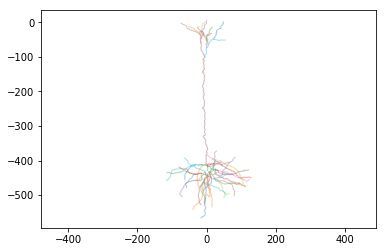

In [3]:
allen_cell_id=lstCells[5]
print allen_cell_id
n=neuron(1)
n.assign_Allen_ID(allen_cell_id)
#n.morph.translate([0,40,0])
#print n.params
#print n.get_param_value('morph_source')
n.import_morphology()
n.morph.draw({'Layout':'Branches','alpha':0.4})
axis('equal')
N.insert_neuron(n)


#N.clear()


#N.topology()

#h.pt3dclear(sec=N.nrn_soma_sec(0))
#h.pt3dadd(0,-5,0,12,N.nrn_soma_sec(0))
#h.pt3dadd(0,0,0,1,N.nrn_soma_sec(0))

#for sec in [s for s in h.allsec() if s.name()[5]=='d']:#[dend1,dend2]:#,dend3]:
#    h.pt3dclear(sec=sec)
#    print sec.name()
#h.topology()

In [ ]:
N.clear()

In [4]:
psh=h.PlotShape()
psh.exec_menu('Show Diam')
h.topology()
#psh.exec_menu('test')


|-|       n001_s0000(0-1)
 `---------|       n001_d0000(0-1)
 `----------|       n001_d0001(0-1)
 `----|       n001_d0002(0-1)
    `---------|       n001_d0003(0-1)
     `-------|       n001_d0004(0-1)
       `--------|       n001_d0005(0-1)
    `|       n001_d0006(0-1)
   `-----------|       n001_d0007(0-1)
          `-----|       n001_d0008(0-1)
 `--------|       n001_d0009(0-1)
  `-|       n001_d0010(0-1)
 `----|       n001_d0011(0-1)
   `----------|       n001_d0012(0-1)
  `--------|       n001_d0013(0-1)
    `---------|       n001_d0014(0-1)
 `-----------|       n001_d0015(0-1)
  `----|       n001_d0016(0-1)
 `-----------|       n001_d0017(0-1)
     `------|       n001_d0018(0-1)
    `----|       n001_d0019(0-1)
    `----|       n001_d0020(0-1)
  `--------|       n001_d0021(0-1)
 `------|       n001_d0022(0-1)
   `----|       n001_d0023(0-1)
  `-------|       n001_d0024(0-1)
    `-------|       n001_d0025(0-1)
     `----------|       n001_d0026(0-1)
   `-----------|       n001_d0

1.0

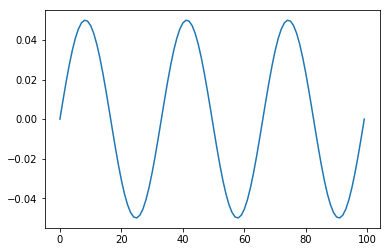

In [263]:

plot([s.amp for s in stim])
from numpy import *

In [6]:
v_s=h.Vector()
v_d1=h.Vector()
v_d2=h.Vector()

t=h.Vector()#(linspace(0.))
i_d3=h.Vector()
t=h.Vector()
t.record(h._ref_t)
sec=N.nrn_dendrite_sec(1,1)
sec_test=N.nrn_dendrite_sec(1,8)
soma=N.nrn_soma_sec(1)
#sec=soma
v_s.record(soma(0.5)._ref_v)
v_d1.record(sec(0.001)._ref_v)
v_d2.record(sec_test(0.8)._ref_v)
h.tstop=100.0

"""stim.delay=20
stim.dur=50
stim.amp=0.010

stim2.delay=30
stim2.dur=0*1
stim2.amp=0.050
"""

'stim.delay=20\nstim.dur=50\nstim.amp=0.010\n\nstim2.delay=30\nstim2.dur=0*1\nstim2.amp=0.050\n'

In [8]:
for sec in h.allsec():
    sec.Ra=100
    sec.cm=1
    if sec.name()[5]=='d':
        sec.diam=1
    elif sec.name()[5]=='s':
        sec.L=sec.diam=20
        sec.insert('hh')
        sec.insert('Nap')
        for seg in sec:
            seg.Nap.gbar_Nap=6e-05
        #    seg.hh.gnabar=0.06 #mS/cm^2
        #    seg.hh.gkbar=0.006 #mS/cm^2
        #    seg.hh.gl=0.00008   #S/cm^2
tstim=linspace(20,20.1,21)
istim=tstim*0+5
s=N.current_to_nrnstim(tstim,istim,soma,0.5)
grid ('on')
h.finitialize(-61)
figure()
h.run()
    #plot(t,v_d2)
plot(t,v_s)
#plot(t,v_d1)
#plot(t,v_d2)
xlim([19,50])

ValueError: argument not a density mechanism name.